## **1. Import libraries**

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lurke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **2. Read dataset**

In [51]:
dataset_path = 'Twitter_Data.csv'
df = pd.read_csv(
    dataset_path
)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [53]:
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## **3. Drop missing value**

In [54]:
null_rows = df.isnull().any(axis=1)
df[null_rows]

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 ...,NaN


In [55]:
df = df.dropna()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


## **4. Preprocessing data**



In [57]:
def text_normalize(text):
    # Lowercasing
    text = text.lower()
    # Retweet old acronym "RT" removal
    text = re.sub(r'~RT[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Hashtag removal
    text = re.sub(r'#', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Steaming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text

In [58]:
text = "door door campaign karyakartas bardowali mondal ward favour our canditate @ pratima bhoumik bar phir modi sarkar bjp zindabad "
text = text_normalize(text)
print(text)

door door campaign karyakarta bardowali mondal ward favour candit pratima bhoumik bar phir modi sarkar bjp zindabad


In [59]:
df['clean_text'] = df['clean_text'].apply(
    lambda x: text_normalize(x)
)

C:\Users\lurke\AppData\Local\Temp\ipykernel_8844\141919810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['clean_text'].apply(


In [60]:
df

,clean_text,category
0,modi promis minimum govern maximum govern expe...,-1.0
1,talk nonsens continu drama vote modi,0.0
2,say vote modi welcom bjp told rahul main campa...,1.0
3,ask support prefix chowkidar name modi great s...,1.0
4,answer among power world leader today trump pu...,1.0
...,...,...
162975,456 crore paid neerav modi recov congress lead...,-1.0
162976,dear rss terrorist payal gawar modi kill 1000 ...,-1.0
162977,cover interact forum left,0.0
162978,big project came india modi dream project happ...,0.0


## **5. Add bias term**

In [61]:
vectorizer = TfidfVectorizer(max_features =2000)
X =vectorizer.fit_transform (df['clean_text']).toarray()

In [62]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate(
    (intercept, X),
    axis=1
)

## **6. One-hot encoding label**

In [63]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)

y_encoded = np.zeros((n_samples, n_classes))

y_encoded[np.arange(n_samples), y] = 1

y_encoded


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## **7. Create train, val, test set**

In [64]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [65]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 114078
Number of val samples: 32594
Number of test samples: 16297


## **7. Define essential functions**

### **7.1. Sigmoid function**

In [66]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1)[:, None] 

### **7.2. Cross-entropy loss function**

In [67]:
def compute_loss(y_hat, y):
    n = y.size

    return (-1 / n) * np.sum(y * np.log(y_hat))

### **7.3. Hypothesis function**

In [68]:
def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)

    return y_hat

### **7.4. Gradient function**

In [69]:
def compute_gradient(X, y, y_hat):
    n = y.size
    gradient = X.T.dot(y_hat - y)
    return (1 / n) * gradient



### **7.5. Update weights function**

In [70]:
def update_theta(theta, gradient, lr):
    theta = theta - lr * gradient
    return theta

### **7.6. Accuracy function**

In [71]:
def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    accuracy = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()
    return accuracy

## **8. Training**

In [72]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(
    size=(n_features, n_classes)
)

In [73]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]

        y_hat = predict(X_i ,theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print (f'\nEPOCH { epoch + 1}:\tTraining loss : {train_batch_loss :.3f}\tValidation loss : {val_batch_loss :.3f}')



EPOCH 1:	Training loss : 0.382	Validation loss : 0.381

EPOCH 2:	Training loss : 0.381	Validation loss : 0.381

EPOCH 3:	Training loss : 0.381	Validation loss : 0.380

EPOCH 4:	Training loss : 0.380	Validation loss : 0.380

EPOCH 5:	Training loss : 0.380	Validation loss : 0.380

EPOCH 6:	Training loss : 0.380	Validation loss : 0.379

EPOCH 7:	Training loss : 0.379	Validation loss : 0.379

EPOCH 8:	Training loss : 0.379	Validation loss : 0.379

EPOCH 9:	Training loss : 0.379	Validation loss : 0.378

EPOCH 10:	Training loss : 0.379	Validation loss : 0.378

EPOCH 11:	Training loss : 0.378	Validation loss : 0.378

EPOCH 12:	Training loss : 0.378	Validation loss : 0.377

EPOCH 13:	Training loss : 0.378	Validation loss : 0.377

EPOCH 14:	Training loss : 0.377	Validation loss : 0.377

EPOCH 15:	Training loss : 0.377	Validation loss : 0.377

EPOCH 16:	Training loss : 0.377	Validation loss : 0.376

EPOCH 17:	Training loss : 0.377	Validation loss : 0.376

EPOCH 18:	Training loss : 0.376	Validat

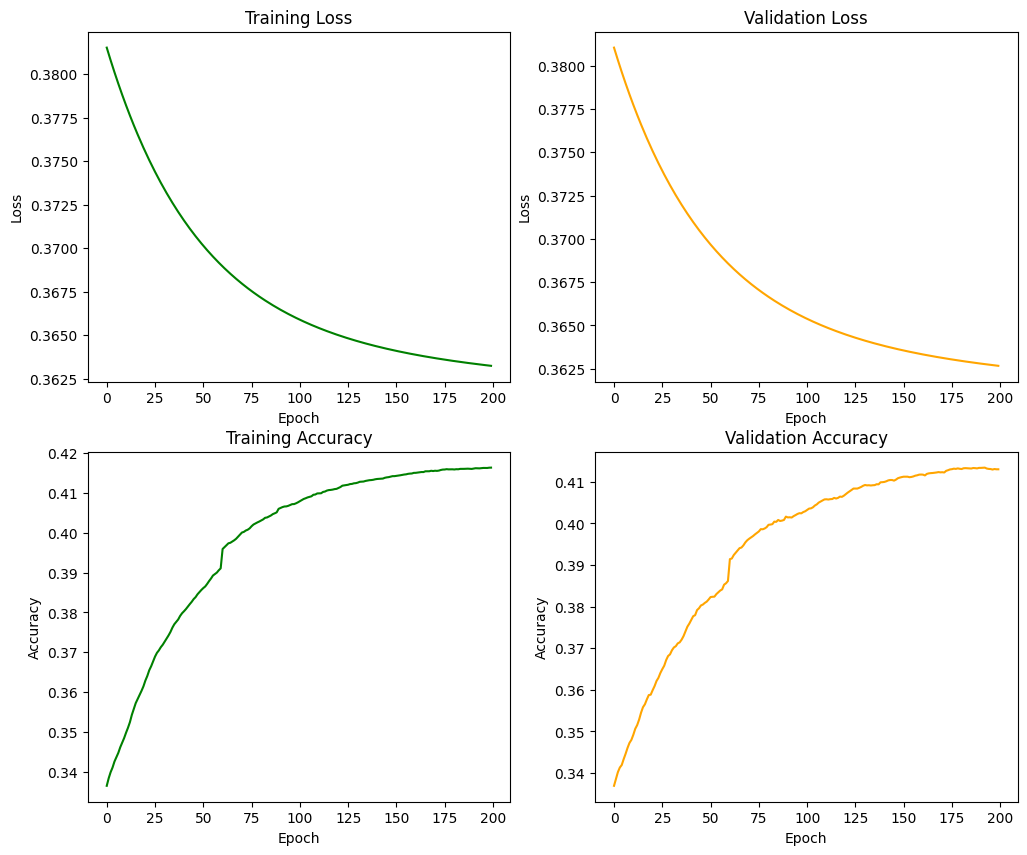

In [74]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **9. Evaluation**

In [75]:
# Val set
val_set_acc = compute_accuracy(X_val, y_val, theta)
print('Evaluation on validation set:')
print(f'Accuracy: {val_set_acc}')

Evaluation on validation set:
Accuracy: 0.4130208013744861


In [76]:
# Test set
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on test set:')
print(f'Accuracy: {test_set_acc}')

Evaluation on test set:
Accuracy: 0.4168251825489354
